# CycleGAN

# Imports

In [1]:
from utils.eval import compute_ssim, plot_results, calculate_fid_from_dataset, calc_content_loss, calc_style_loss

from tqdm import tqdm
from torch.autograd import Variable
from PIL import Image

import numpy as np
import itertools
import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import models.CycleGAN as cyclegan 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyper-parameters

In [2]:
cuda = torch.cuda.is_available()

# Hyper-parameters
lr = 0.0002
batch_size = 64
num_epochs = 100
b1 = 0.5
b2 = 0.999
decay_epoch = 25
sample_interval = 100
checkpoint_interval = 100
n_residual_blocks = 9
lambda_cyc = 10.0
lambda_id = 5.0

# Dataset
num_channels = 3
img_height = 64
img_width = 64
input_shape = (num_channels, img_height, img_width)

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Dataset and Dataloaders

In [ ]:
# Calculate mean and std of dataset
test_tf = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])
dataset = cyclegan.ImageDataset(transform=test_tf, unaligned=True)

total_mean_A, total_mean_B, total_std_A, total_std_B = 0.0, 0.0, 0.0, 0.0

for i in tqdm(range(0, len(dataset))):
    batch = dataset[i]
    img_A = batch['A']
    img_B = batch['B']
    
    mean_A = torch.mean(img_A, dim=(1, 2))
    mean_B = torch.mean(img_B, dim=(1, 2))
    std_A = torch.std(img_A, dim=(1, 2))
    std_B = torch.std(img_B, dim=(1, 2))
    total_mean_A += mean_A
    total_mean_B += mean_B
    total_std_A += std_A
    total_std_B += std_B
    
mean = (total_mean_A + total_mean_B) / (len(dataset) * 2)
std = (total_std_A + total_std_B) / (len(dataset) * 2)
print(mean) # tensor([0.4820, 0.4424, 0.3893]) 
print(std) # tensor([0.2064, 0.1953, 0.1880])

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop(size=(img_width, img_height)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4820, 0.4424, 0.3893), (0.2064, 0.1953, 0.1880)),
])

val_tf = transforms.Compose([
    transforms.Resize(size=(img_width, img_height)),
    transforms.ToTensor(),
])

# Training data loader
train_dataloader = DataLoader(
    cyclegan.ImageDataset(transform=train_tf, unaligned=True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

# Test data loader
val_dataloader = DataLoader(
    cyclegan.ImageDataset(transform=val_tf, unaligned=True, mode="val"),
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
)

# Run model training

In [ ]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Initialize generator and discriminator
G_AB = cyclegan.GeneratorResNet(input_shape, n_residual_blocks)
G_BA = cyclegan.GeneratorResNet(input_shape, n_residual_blocks)
D_A = cyclegan.Discriminator(input_shape)
D_B = cyclegan.Discriminator(input_shape)

G_AB = G_AB.to(device)
G_BA = G_BA.to(device)
D_A = D_A.to(device)
D_B = D_B.to(device)
criterion_GAN.to(device)
criterion_cycle.to(device)
criterion_identity.to(device)


# Initialize weights
G_AB.apply(cyclegan.weights_init_normal)
G_BA.apply(cyclegan.weights_init_normal)
D_A.apply(cyclegan.weights_init_normal)
D_B.apply(cyclegan.weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

# Learning rate update schedulers
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=cyclegan.LambdaLR(num_epochs, 0, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=cyclegan.LambdaLR(num_epochs, 0, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=cyclegan.LambdaLR(num_epochs, 0, decay_epoch).step
)


# Buffers of previously generated samples
fake_A_buffer = cyclegan.ReplayBuffer()
fake_B_buffer = cyclegan.ReplayBuffer()

In [ ]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, f"./models/output/CycleGAN/images/{batches_done}.png", normalize=False)

# ----------
#  Training function
# ----------
def cyclegan_train():
    D_losses = []
    G_losses = []
    adv_losses = []
    cycle_losses = []
    I_losses = []
    prev_time = time.time()
    for epoch in range(num_epochs):
        print('.' * 64)
        print(f"--- Epoch {epoch + 1}/{num_epochs} ---")
        pbar = tqdm(train_dataloader, leave=False)
        agg_D_loss = 0.0
        agg_G_loss = 0.0
        agg_adv_loss = 0.0
        agg_cycle_loss = 0.0
        agg_I_loss = 0.0
        for i, batch in enumerate(pbar):
            pbar.set_description(f"Epoch [{epoch + 1}/{num_epochs}]")
            # Set model input
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))

            # Adversarial ground truths
            valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
            fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

            # ------------------
            #  Train Generators
            # ------------------

            G_AB.train()
            G_BA.train()

            optimizer_G.zero_grad()

            # Identity loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A)
            loss_id_B = criterion_identity(G_AB(real_B), real_B)

            loss_identity = (loss_id_A + loss_id_B) / 2
            agg_I_loss += loss_identity.item()

            # GAN loss
            fake_B = G_AB(real_A)
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

            loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
            agg_adv_loss += loss_GAN.item()

            # Cycle loss
            recov_A = G_BA(fake_B)
            loss_cycle_A = criterion_cycle(recov_A, real_A)
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
            agg_cycle_loss += loss_cycle.item()

            # Total loss
            loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
            agg_G_loss += loss_G.item()
            
            loss_G.backward()
            optimizer_G.step()

            # -----------------------
            #  Train Discriminator A
            # -----------------------

            optimizer_D_A.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_A(real_A), valid)
            # Fake loss (on batch of previously generated samples)
            fake_A_ = fake_A_buffer.push_and_pop(fake_A)
            loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
            # Total loss
            loss_D_A = (loss_real + loss_fake) / 2

            loss_D_A.backward()
            optimizer_D_A.step()

            # -----------------------
            #  Train Discriminator B
            # -----------------------

            optimizer_D_B.zero_grad()

            # Real loss
            loss_real = criterion_GAN(D_B(real_B), valid)
            # Fake loss (on batch of previously generated samples)
            fake_B_ = fake_B_buffer.push_and_pop(fake_B)
            loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
            # Total loss
            loss_D_B = (loss_real + loss_fake) / 2

            loss_D_B.backward()
            optimizer_D_B.step()

            loss_D = (loss_D_A + loss_D_B) / 2
            agg_D_loss += loss_D.item()

            # --------------
            #  Log Progress
            # --------------

            # Determine approximate time left
            batches_done = epoch * len(train_dataloader) + i
            batches_left = num_epochs * len(train_dataloader) - batches_done
            time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
            prev_time = time.time()


            # If at sample interval save image
            if batches_done % sample_interval == 0:
                sample_images(batches_done)
                

        D_losses.append(agg_D_loss / (i + 1))
        G_losses.append(agg_G_loss / (i + 1))
        adv_losses.append(agg_adv_loss / (i + 1))
        cycle_losses.append(agg_cycle_loss / (i + 1))
        I_losses.append(agg_I_loss / (i + 1))
        
        # Print log
        print(f"[D loss: {loss_D.item()}] [G loss: {loss_G.item()}, adv: {loss_GAN.item()}, cycle: {loss_cycle.item()}, identity: {loss_identity.item()}] ETA: {time_left}")

        # Update learning rates
        lr_scheduler_G.step()
        lr_scheduler_D_A.step()
        lr_scheduler_D_B.step()


    torch.save(G_AB.state_dict(), f"./models/output/CycleGAN/G_AB_trained_{epoch}.pth")
    torch.save(G_BA.state_dict(), f"./models/output/CycleGAN/G_BA_trained_{epoch}.pth")
    torch.save(D_A.state_dict(), f"./models/output/CycleGAN/D_A_trained_{epoch}.pth")
    torch.save(D_B.state_dict(), f"./models/output/CycleGAN/D_B_trained_{epoch}.pth")
            
    return D_losses, G_losses, adv_losses, cycle_losses, I_losses

In [ ]:
D_losses, G_losses, adv_losses, cycle_losses, I_losses = cyclegan_train()

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(D_losses)
plt.plot(G_losses)
plt.plot(adv_losses)
plt.plot(cycle_losses)
plt.plot(I_losses)
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator', 'GAN', 'Cycle', 'Identity'], loc='upper left')

plt.figure()
plt.plot(D_losses)
plt.plot(adv_losses)
plt.plot(cycle_losses)
plt.plot(I_losses)
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'GAN', 'Cycle', 'Identity'], loc='upper left')

plt.show()

# Run model evaluation

In [3]:
# Load pretrained model for style transfer
G_AB = cyclegan.GeneratorResNet(input_shape, n_residual_blocks)
G_AB.load_state_dict(torch.load("./models/output/CycleGAN/G_AB_trained_99.pth"))

<All keys matched successfully>

In [11]:
test_tf = transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

test_dataloader = DataLoader(
    cyclegan.ImageDatasetTesting(transform=test_tf, mode="val"),
    batch_size=64,
    shuffle=False
)

def cyclegan_eval(G_AB, test_dataloader):
    G_AB.to(device)
    ssim_sum = 0.0
    fid_sum = 0.0
    running_content_loss, running_style_loss = 0.0, 0.0
    total_samples = 0
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        for i, batch in enumerate(pbar):
            real_A = Variable(batch["A"].type(Tensor))
            real_B = Variable(batch["B"].type(Tensor))
            style_labels = batch["label"]
            output = G_AB(real_A)
            
            # Compute quantitative evaluation metrics
            ssim_sum += compute_ssim(real_A, output)
            fid_sum += calculate_fid_from_dataset(real_A, output, device, dims=2048)
            running_content_loss += calc_content_loss(real_A, output)
            running_style_loss += calc_style_loss(real_B, output)

            # Display qualitative evaluation metrics on first batch
            if total_samples == 0:
                plot_results(real_A, real_B, style_labels, output, nrows=5, model_name="CycleGAN")
            total_samples += real_A.size(0)
            
    avg_ssim = ssim_sum / total_samples
    avg_fid = fid_sum / total_samples
    avg_content_loss = running_content_loss / total_samples
    avg_style_loss = running_style_loss / total_samples
    return avg_ssim, avg_fid, avg_content_loss, avg_style_loss

  0%|          | 0/15 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


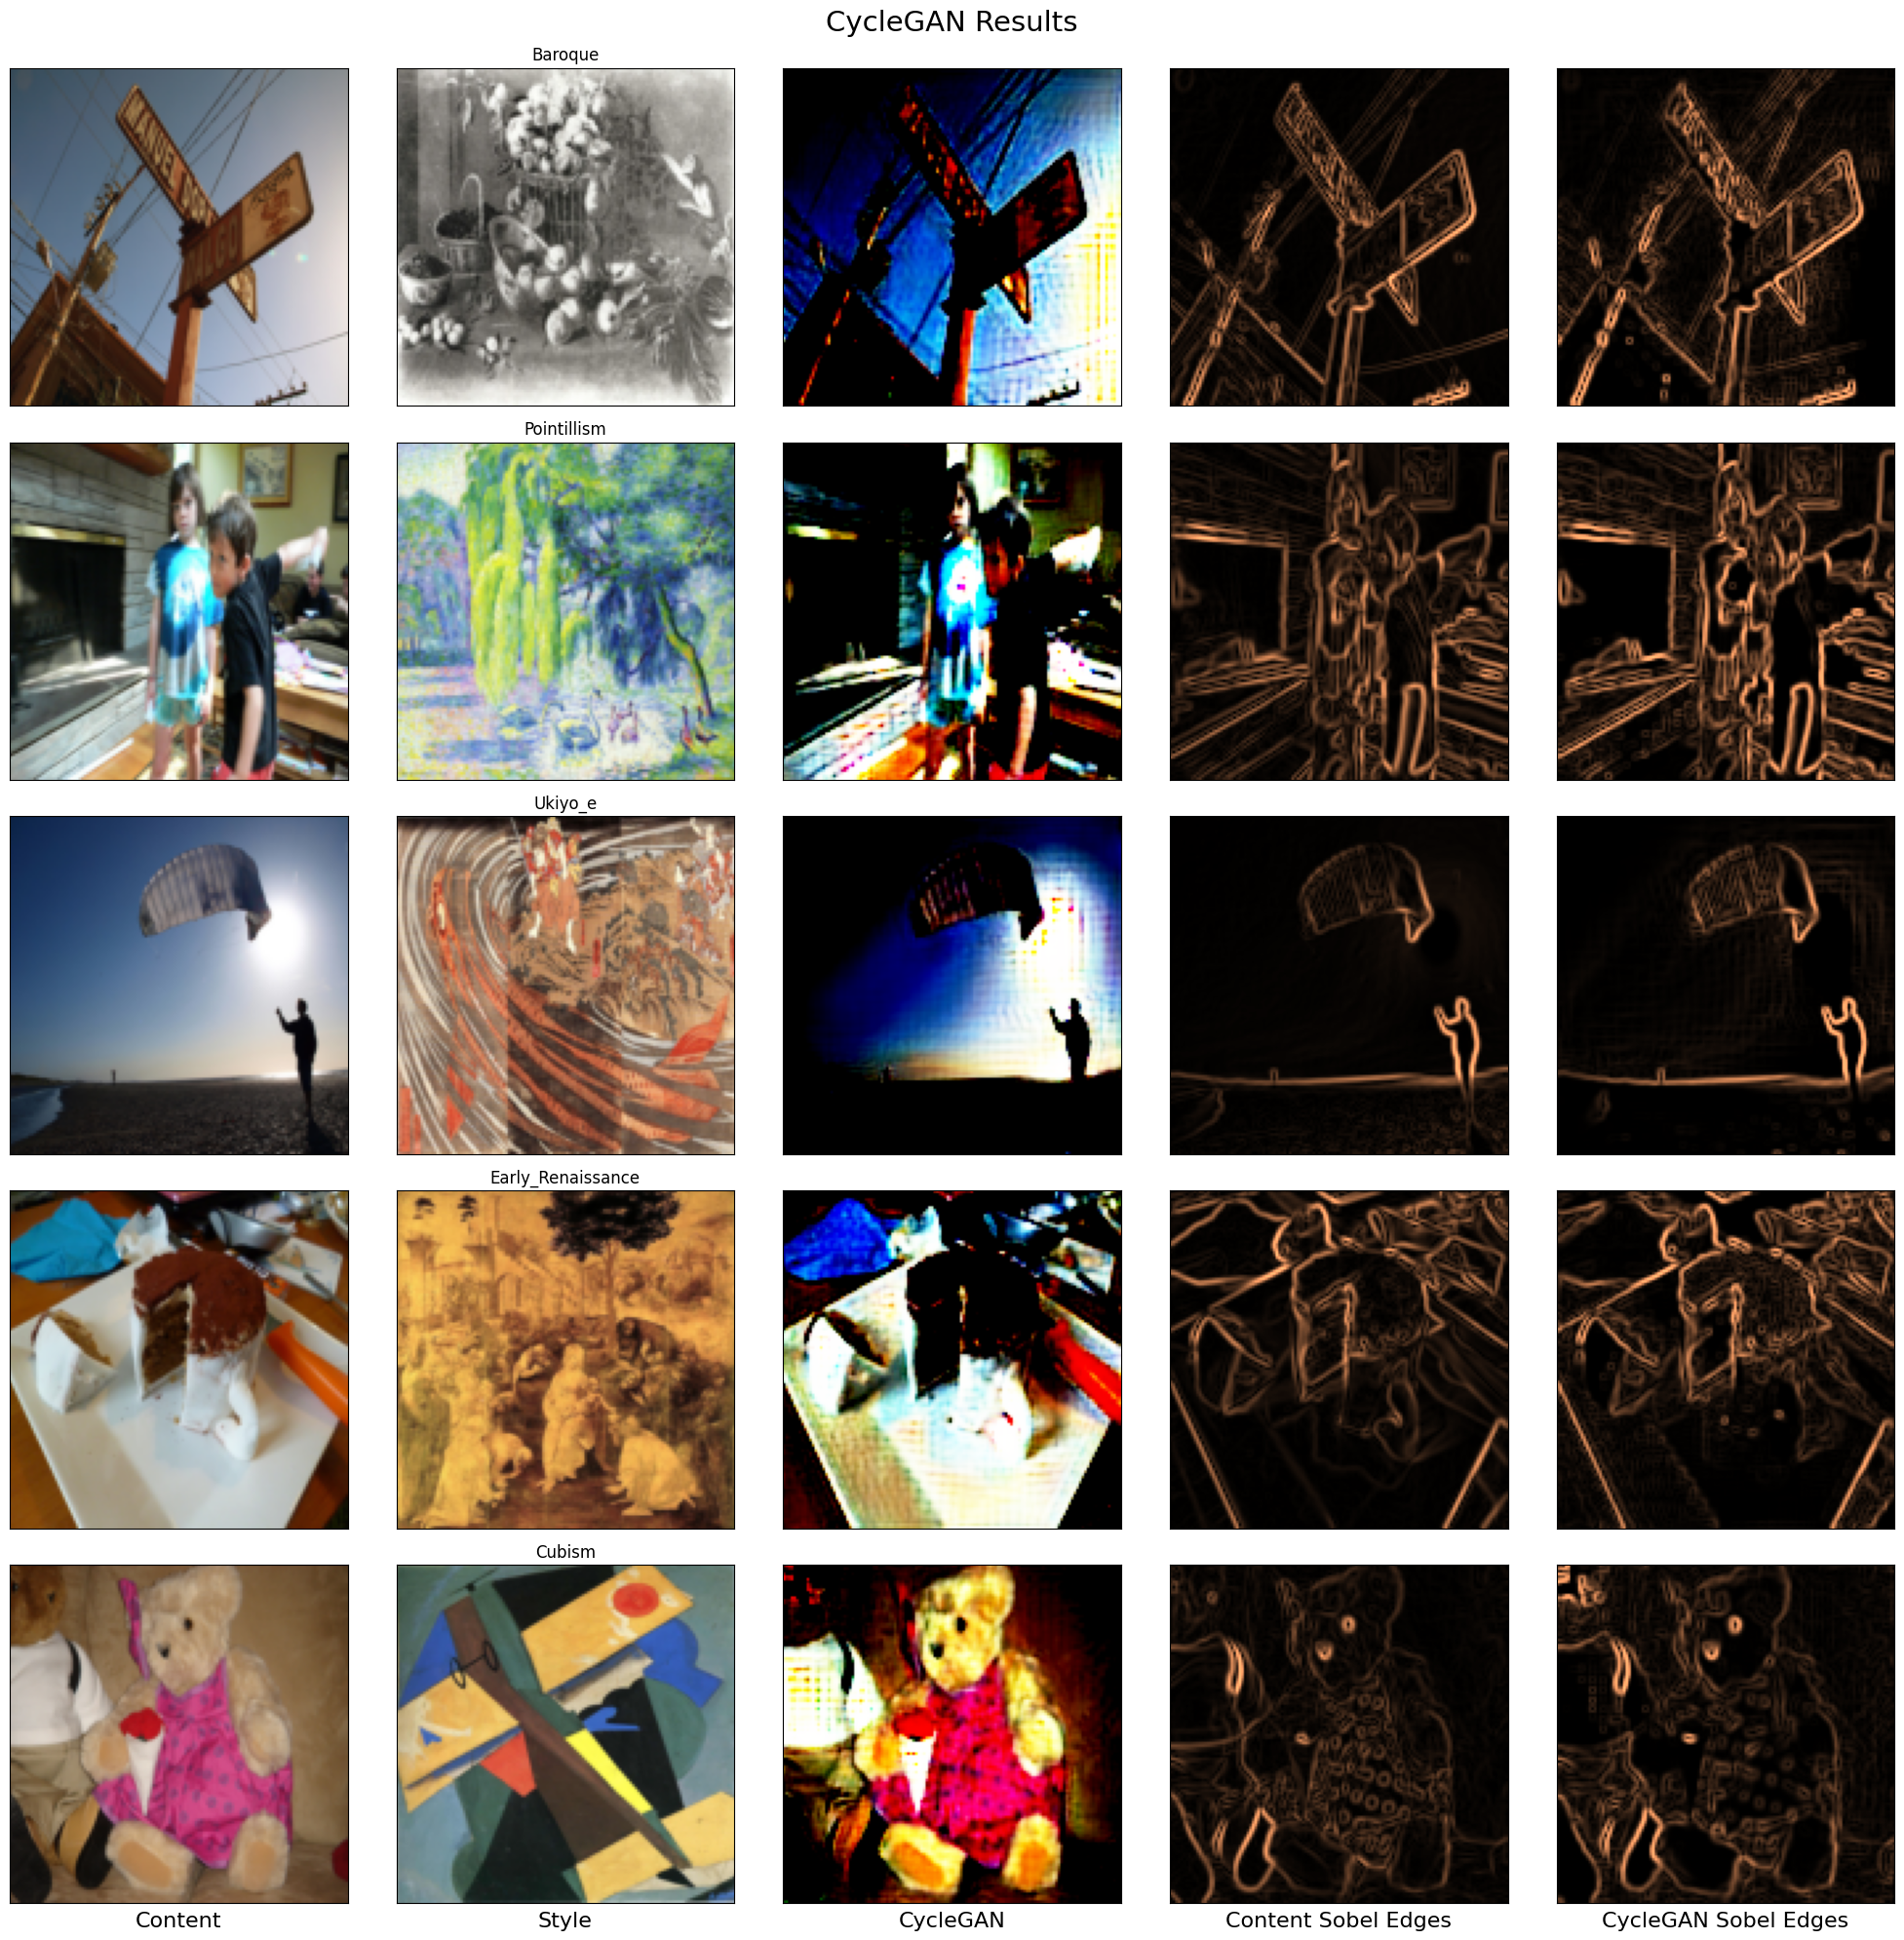

100%|██████████| 15/15 [02:11<00:00,  8.73s/it]


In [12]:
cyclegan_ssim, cyclegan_fid, cyclegan_content_loss, cyclegan_style_loss = cyclegan_eval(G_AB, test_dataloader)

In [13]:
print("--- CycleGAN results ---")
print(f"Average SSIM = {cyclegan_ssim:.7f}")
print(f"Average FID = {cyclegan_fid:.4f}")
print(f"Average content loss = {cyclegan_content_loss:.4f}")
print(f"Average style loss = {cyclegan_style_loss:.4f}")

--- CycleGAN results ---
Average SSIM = 0.1146433
Average FID = 35.3033
Average content loss = 0.0074
Average style loss = 0.0094
